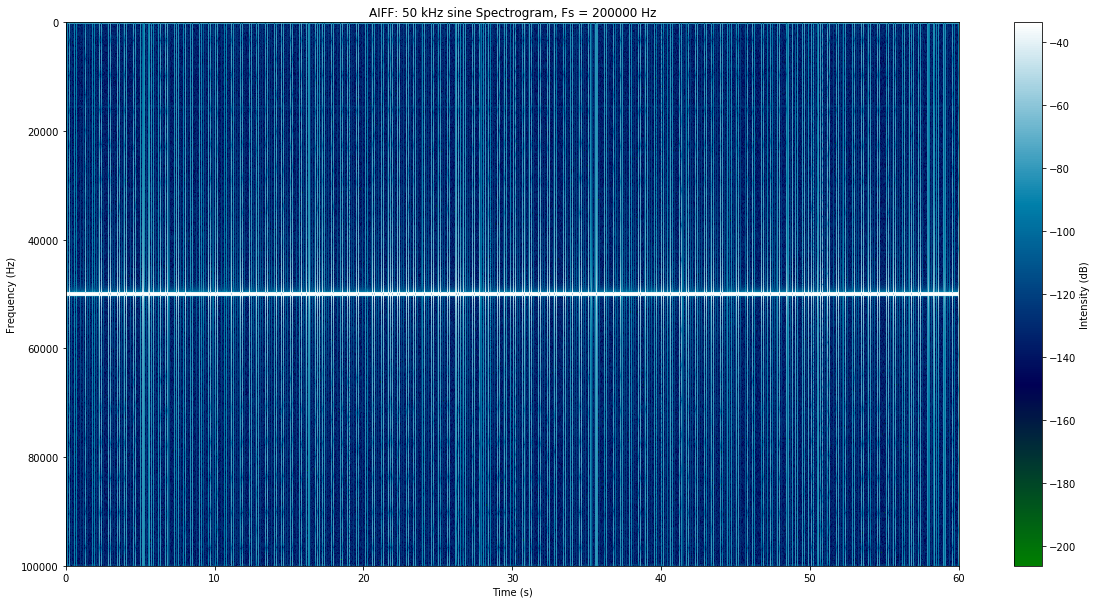

In [3]:
import matplotlib.pyplot as plt
import math
import pandas as pd
import soundfile as sf
import numpy as np
from numpy import fft

##### Dictionaries of test files #####

csvDict = {
    "48 kHz sine": 
    "csv/100/sine/48kHz100_20180909T024527672838Z.csv",
    
    "38-25 kHz 1 ms sweep": 
    "csv/100/sweep/38-25kHz100_20131219T02090670580Z.csv",
    
    "96 kHz sine": 
    "csv/200/sine/96kHz200_20180909T033007480050Z.csv",
    
    "75-50 kHz 1 ms sweep": 
    "csv/200/sweep/75-50kHz200_20131219T021143244776Z.csv",
    
    "192 kHz sine": 
    "csv/400/sine/192kHz400_20131219T021907434105Z.csv",
    
    "150-100 kHz 1 ms sweep": 
    "csv/400/sweep/150-100kHz400_20131219T021421308345Z.csv",
    
    "50 kHz sine": 
    "tests/50kHz200_20180910T011832538989Z.csv",
    
    "50 kHz sine recorded with aio-in": 
    "tests/50kHz200aio.csv",
    
    "96 kHz sine recorded with aio-in": 
    "tests/96kHz200aio.csv",
    
    "test":
    "tests/50kHz200_20180919T000005593562Z.csv"
}

cvsFreqDict = {
    "48 kHz sine": 100000,
    "38-25 kHz 1 ms sweep": 100000,
    "96 kHz sine": 200000,
    "75-50 kHz 1 ms sweep": 200000,
    "192 kHz sine": 400000,
    "150-100 kHz 1 ms sweep": 400000,
    "50 kHz sine": 200000,
    "50 kHz sine recorded with aio-in": 200000,
    "96 kHz sine recorded with aio-in": 200000,
    "test": 200000
}

aiffDict = {
    "48 kHz sine": 
    "aiff/100/sine/48kHz100_20180911T062226700725Z.aiff",
    
    "38-25 kHz 1 ms sweep": 
    "aiff/100/sweep/38-25kHz100_20180911T06432384485Z.aiff",
    
    "96 kHz sine": 
    "aiff/200/sine/96kHz200_20180911T062911695433Z.aiff",
    
    "75-50 kHz 1 ms sweep": 
    "aiff/200/sweep/75-50kHz200_20180911T064630568199Z.aiff",
    
    "192 kHz sine": 
    "aiff/400/sine/192kHz400_20180911T063429741633Z.aiff",
    
    "150-100 kHz 1 ms sweep": 
    "aiff/400/sweep/150-100kHz400_20180911T0653024680Z.aiff",
    
    "50 kHz sine 2 min":
    "tests/50kHz2002min_20180919T0323Z.aiff",
    
    "50 kHz sine":
    "tests/50kHz200_20180919T081121769471Z.aiff"
}

##### Functions #####

#
# CSV moving picture frame-by-frame plotter.
# Has special function to show dropoffs
#

def plotCSVFrame(waveform, plot, N0, N):
    T = 500; # samples per frame
    wait = 2; # delay in seconds
    
    fs = cvsFreqDict.get(waveform)
    fileName = csvDict.get(waveform)
    fileCSV = pd.read_csv(fileName)

    allData = fileCSV.values
    voltData = allData[:, 1] # analagous to fileCSV.loc[:].iat[1]
    countData = allData[:, 2]

    N_max = math.floor(len(voltData) / T)

    if plot is 'time':
        if (N0 >= 0) and (N0 <= N) and (N <= N_max):
            frames = range(N0, N)

            plt.ion()
            plt.show()
            for i in frames:
                n0 = T * i # initial sample
                n = n0 + T # final sample
                ni = np.array(range(n0, n))
                ti = ni * 1000 / fs
                plt.figure(figsize=(20,10))
                markerline, stemlines, baseline = plt.stem(ti, voltData[ni], linefmt='C0--')
                plt.setp(baseline, linewidth=0.5, color='black')
                plt.setp(stemlines, linewidth=0.5)
                plt.title('CSV %s (Fs = %d Hz): Frame %d / %d' % (waveform, fs, i + 1, N))
                plt.ylim(-10, 10)
                plt.xlim(ti[0], ti[-1])
                plt.ylabel('Amplitude (V)')
                plt.xlabel('Time (ms)')
                plt.draw() 
                plt.pause(wait)
                plt.close()
        else:
            print("Error: initial frame number %d must be:\n" % N0)
            print("\t no more than the final frame number %d\n" % N)
            print("\t at least 0\n")
    elif plot is 'spikes':
        thres = 5.1 # 5 V + 2%
        data = np.array(voltData)
        diff = data * (abs(data) > thres)
        indices = np.where(diff > 0)
        plt.scatter(indices, diff[indices])
        plt.grid()
        plt.title('Spikes')
        plt.xlabel('Sample')
        plt.xlim(0, len(data) - 1)
        plt.ylabel('Amplitude (V)')
        plt.ylim(-10, 10)
        plt.show() 
    else:
        print("Error: invalid option; only 'time' and 'spikes' allowed\n")

#
# Plots CSV file in time- and frequency domain for given range. 
# The given range defines the initial and final sample to be plotted.
#

def plotDomainsCSV(waveform, N0, N):    
    fs = cvsFreqDict.get(waveform)
    fileName = csvDict.get(waveform)
    fileCSV = pd.read_csv(fileName)

    allData = fileCSV.values
    volts = 1
    counts = 2
    voltData = allData[:,volts] # analagous to fileCSV.loc[:].iat[1]

    if N is -1:
        N = len(voltData)
            
    if (N <= len(voltData)) and (N0 >= 0) and (N > N0):
        t = 1000*np.linspace(N0, N, N-N0)/fs
        plt.figure(1, figsize=(20,10))
        markerline, stemlines, baseline = plt.stem(t, voltData[N0:N], linefmt='C0--')
        plt.setp(baseline, linewidth=0.5, color='black')
        plt.setp(stemlines, linewidth=0.5)
        plt.title('CSV: ' + waveform + ' in time-domain, Fs = ' + str(fs) + ' Hz')
        plt.xlabel('Time (ms)')
        plt.ylabel('Amplitude (V)')
        plt.show()

        voltFFT = np.fft.fft(voltData[N0:N])
        f = np.linspace(-fs/2,(fs/2)-1,len(voltFFT))
        plt.figure(2, figsize=(20,10))
        fftMag = abs(np.fft.fftshift(voltFFT))
        markerline, stemlines, baseline = plt.stem(f, fftMag/max(fftMag), markerfmt=' ')
        plt.setp(baseline, linewidth=0.5, color='black')
        plt.title('CSV: ' + waveform + ' in frequency-domain, Fs = ' + str(fs) + ' Hz')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Normalised Absolute Magnitude')
        plt.show()


def plotDomainsAllCSV(N0, N):    
    for waveform in csvDict:
        plotDomainsCSV(waveform, N0, N)

#   
# Plots AIFF or CSV file in time-domain in real-time
#
def plotDomainsAIFF(waveform, N0, N):
    fileName = aiffDict.get(waveform)
    fileAIFF, fs = sf.read(fileName)
    
    if N is -1:
        N = len(fileAIFF)
            
    if (N <= len(fileAIFF)) and (N0 >= 0) and (N > N0):
        t = 1000*np.linspace(N0, N, N-N0)/fs
        plt.figure(1, figsize=(20,10))
        markerline, stemlines, baseline = plt.stem(t, fileAIFF[N0:N], linefmt='C0--')
        plt.setp(baseline, linewidth=0.5, color='black')
        plt.setp(stemlines, linewidth=0.5)
        plt.title('AIFF: ' + waveform + ' in time-domain, Fs = ' + str(fs) + ' Hz')
        plt.xlabel('Time (ms)')
        plt.ylabel('Normalised Amplitude')
        plt.show()

        fileFFT = np.fft.fft(fileAIFF[N0:N])
        f = np.linspace(-fs/2,(fs/2)-1,len(fileFFT))
        plt.figure(2, figsize=(20,10))
        fftMag = abs(np.fft.fftshift(fileFFT))
        markerline, stemlines, baseline = plt.stem(f, fftMag/max(fftMag), markerfmt=' ')
        plt.setp(baseline, linewidth=0.5, color='black')
        plt.title('AIFF: ' + waveform + ' in frequency-domain, Fs = ' + str(fs) + ' Hz')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Normalised Absolute Magnitude')
        plt.show()

def plotDomainsAllAIFF(N0, N):    
    for waveform in aiffDict:
        plotDomainsAIFF(waveform, N0, N)

def plotDomains(waveform, fileType, N0, N):
    if fileType is "aiff":
        plotDomainsAIFF(waveform, N0, N)
    elif fileType is "csv":
        plotDomainsCSV(waveform, N0, N)
    else:
        print("invalid file type\n")

#
# Plots spectrogram for entire CSV or AIFF file
#
def plotRealTimeSpecgram(waveform, fileType, N0, N):    
    if fileType is "csv":
        fs = cvsFreqDict.get(waveform)
        fileName = csvDict.get(waveform)
        fileCSV = pd.read_csv(fileName)

        allData = fileCSV.values
        voltData = allData[:, 1] # analagous to fileCSV.loc[:].iat[1]
        countData = allData[:, 2]

        ymin = -10
        ymax = 10
    elif fileType is "aiff":
        fileName = aiffDict.get(waveform)
        fileAIFF, fs = sf.read(fileName)
        voltData = fileAIFF

        ymin = -1
        ymax = 1
    else:
        print("invalid file type\n")

    if N0 >= 0 and N <= len(voltData):
        def get_specgram(signal, rate):
            nfft = 1024 #NFFT value for spectrogram
            overlap = 512 #overlap value for spectrogram
            arr2D, freqs, bins, im = ax.specgram(signal, Fs=rate, NFFT=nfft, noverlap=overlap, cmap='ocean', scale='dB')
            return arr2D, freqs, bins, im

        fig, ax = plt.subplots(figsize=(20,10))
        arr2D, freqs, bins, im = get_specgram(voltData[N0:N], fs)
        plt.xlabel('Time (s)')
        plt.ylabel('Frequency (Hz)')
        plotTitle = ': ' + waveform + ' Spectrogram, Fs = ' + str(fs) + ' Hz'
        if fileType is "csv":
            plotTitle = 'CSV' + plotTitle
        elif fileType is 'aiff':
            plotTitle = 'AIFF' + plotTitle
        plt.title(plotTitle)
        cbar = plt.colorbar(mappable=im)
        cbar.set_label('Intensity (dB)')
        plt.gca().invert_yaxis()
        plt.show()

    
##### Plots #####

N0 = 0 # initial sample (initial time = N / fs)
N = -1 # final sample (final time = N / fs), -1 for last sample

# Plots spectrogram of entire CSV or AIFF file
fileType = "aiff"
waveform = "50 kHz sine"
plotRealTimeSpecgram(waveform, fileType, N0, N)
# plotDomains(waveform, fileType, N0, N)

#Plots time- and frequency-domain for all test files in dictionaries
# plotDomainsCSV(N0, N)
# plotDomainsAIFF(N0, N)

#Plots CSV file in time-domain, frame-by-frame
# plot = 'time';
# waveform = "48 kHz sine"
# F = 10 # final frame
# F0 = 0 #initial frame
# plotCSVFrame(waveform, plot, F0, F)